<a href="https://colab.research.google.com/github/kasri-mids/MovieGenreClassification/blob/master/src/Data/5_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to generate our dataset, we took the list of IMDB movie ID's and wrote scripts to extract the movie name, year, genres, language, movie plot and the thumbnail. This is then saved in an `imdb_dataset.csv` file. All this work is done in the `Dataset.ipynb` notebook in Google Colab along with AWS.

Then, within our `Parsing Data` notebook, we load this dataset and do the following

1. Convert csv file to pandas dataframe
2. Create a new column genre_list that is a list of strings for each movie
3. Remove rows that don't have any genre's associated
4. Create a new column plot_len that is the length of the plot summary for each movie
5. Based on the quantiles from our plot lengths, we remove plot lengths of less than 15 and greater than 545
6. One Hot Encoded the variables
7. Did a genre count for the entire dataset and took the top 10 genres
8. Merged this dataset with the poster feature vectors saved in `data/posters/poster_features.csv.zip`
9. Removed the feature vectors that were NA's
10. Created a labels list which takes the one-hot encoded values of the ten genres and creates a comma separated list out of that
10. Ended up with a dataset of 78008 rows and the columns 'movieid', 'movieplot', 'feature_vector' and 'label'

 

In [0]:
# Imports

import json
import pandas as pd
import numpy as np
import os
import sys
import io
import re
import matplotlib.pyplot as plt

from time import time
from csv import reader
from matplotlib import colors
from datetime import datetime
from matplotlib.ticker import PercentFormatter
from google.colab import drive

In [0]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/clean_poster_data_10.csv')
original_df = pd.read_csv('/content/drive/My Drive/w266-FinalProject/data/imdb_dataset.csv')

In [0]:
df.head()
df.shape

(78008, 4)

In [0]:
original_df.head()
original_df.shape

(81271, 7)

## Data Exploration

### 1. Describing Dataset

We have 78,008 unique movie id's in our dataset and for each movie id, we have a corresponding movie plot summary, the feature vector for the poster of that movie and the genre labels

In [0]:
df.head()

,movieid,movieplot,feature_vector,labels
0,tt0007610,A judge who had taken part in the gold rush of...,"[0.7366994023323059, 0.9941093921661377, 1.076...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,tt0005078,"Richard Hardy, a hardworking stockbroker, labo...","[0.002950882539153099, 0.10090522468090057, 1....","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,tt0007257,"Reggie, a wealthy young man about town, is eag...","[0.03462240472435951, 0.500708818435669, 1.862...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
3,tt0008011,"Living in the country with her widowed mother,...","[0.0, 0.06257307529449463, 0.8574206233024597,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt0003772,Based on the fairy tale: Cinderella is mistrea...,"[0.2867472171783447, 0.0, 0.9653348922729492, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [0]:
df['movieid'].describe()

count         78008
unique        78008
top       tt0037175
freq              1
Name: movieid, dtype: object

### 2. Genre Counts

In [0]:
# Question : Where are we preserving this order for the labels when we validate?

In [0]:
count_dict = {
    'Drama': 0, 
    'Thriller': 0, 
    'Comedy': 0, 
    'Action':0 , 
    'Crime': 0, 
    'Horror': 0, 
    'Romance': 0, 
    'Adventure':0, 
    'Mystery': 0, 
    'Sci-Fi':0 
}

lookup = {
    0 : 'Drama',
    1 : 'Thriller',
    2 : 'Comedy',
    3 : 'Action',
    4 : 'Crime',
    5 : 'Horror',
    6 : 'Romance',
    7 : 'Adventure',
    8 : 'Mystery',
    9 : 'Sci-Fi'
}

for index, labels in enumerate(df.labels):
    labels = labels.strip('][').split(', ') 
    for i in range(10):
        count_dict[lookup[i]] += int(labels[i])

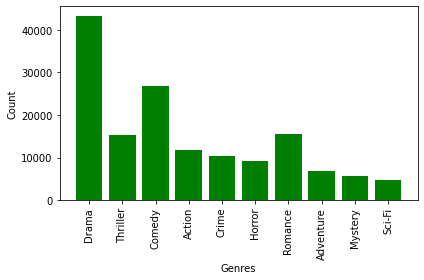

In [0]:
import matplotlib.pyplot as plt

plt.bar(count_dict.keys(), count_dict.values(), color='g')
plt.xticks(rotation='vertical')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("genreCount.png",dpi=300)

In [0]:
count_dict

{'Action': 11831,
 'Adventure': 6922,
 'Comedy': 26861,
 'Crime': 10328,
 'Drama': 43367,
 'Horror': 9222,
 'Mystery': 5736,
 'Romance': 15472,
 'Sci-Fi': 4703,
 'Thriller': 15247}

### 3. Plot Lengths

In [0]:
# Generate plot_len and then take a look at quantiles
def plot_length():
  new_list = []
  for res in df.movieplot:
    new_list.append(len(res.split(" ")))
  return new_list

plot_len_list = plot_length()
np.quantile(plot_len_list, [0.01,0.25,0.5,0.75,0.999])

array([ 17.,  39.,  73., 119., 477.])

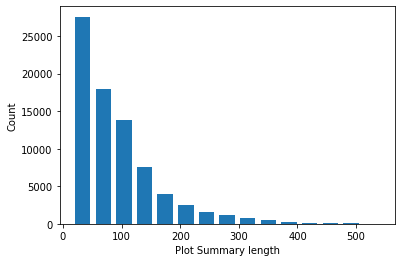

In [0]:
plt.hist(plot_len_list, bins = 15, rwidth = 0.75)
plt.xlabel("Plot Summary length")
plt.ylabel("Count")
plt.show()

### 4. Movie Languages

In [0]:
# 154 different languages
original_df.language.nunique()

154

In [0]:
original_df.language.value_counts(dropna=True)

English       39612
French         4530
Spanish        2531
Japanese       2523
Italian        2395
              ...  
Belarusian        1
Sanskrit          1
Chechen           1
Purepecha         1
Tzotzil           1
Name: language, Length: 154, dtype: int64

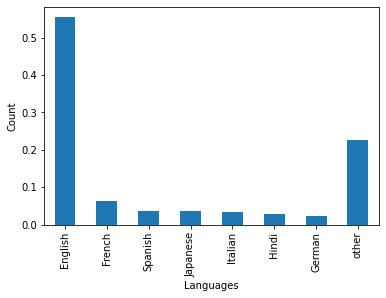

In [0]:
prob = original_df.language.value_counts(normalize=True, dropna=True)
threshold = 0.02
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel("Languages")
plt.ylabel("Count")
plt.show()

### 5. Movie Years

Our dataset contains movies from 111 different years, ranging from 1906 to 2020, with the most movies in 2017. We also generate a plot that bins the movies into years such as 1980 - 1990, 2010 - 2020 etc  

In [0]:
# Remove empty rows
original_df = original_df[~(original_df['year'] == '|')]
original_df = original_df[~(original_df['year'] == 'original title')]
original_df.year = original_df.year.astype(int)

In [0]:
original_df.year.min()

1906

In [0]:
original_df.year.max()

2020

In [0]:
original_df.year.nunique()

111

In [0]:
original_df.year.value_counts()

2017    3110
2016    3028
2015    2897
2018    2875
2014    2857
        ... 
1913      13
1912       5
1911       4
2020       3
1906       1
Name: year, Length: 111, dtype: int64

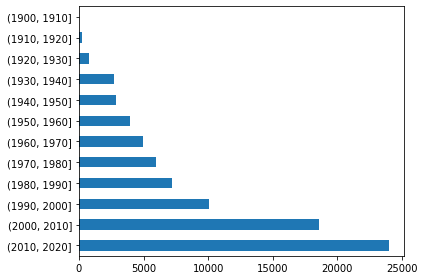

In [0]:
bins = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
# original_df['binned'] = pd.cut(original_df['year'], bins)
s = pd.cut(original_df['year'], bins=bins).value_counts()
s.plot(kind='barh')
plt.tight_layout()
plt.savefig("yearlyPrediction.png",dpi=300)

## Co-Occurrence Matrix

In [0]:
df.head()

,movieid,movieplot,feature_vector,labels
0,tt0007610,A judge who had taken part in the gold rush of...,"[0.7366994023323059, 0.9941093921661377, 1.076...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,tt0005078,"Richard Hardy, a hardworking stockbroker, labo...","[0.002950882539153099, 0.10090522468090057, 1....","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,tt0007257,"Reggie, a wealthy young man about town, is eag...","[0.03462240472435951, 0.500708818435669, 1.862...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
3,tt0008011,"Living in the country with her widowed mother,...","[0.0, 0.06257307529449463, 0.8574206233024597,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt0003772,Based on the fairy tale: Cinderella is mistrea...,"[0.2867472171783447, 0.0, 0.9653348922729492, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [0]:
headers = ['Drama','Thriller','Comedy','Action','Crime','Horror','Romance','Adventure','Mystery','Sci-Fi']

In [0]:
import ast
final_l = []
for label in df.labels:
    l = ast.literal_eval(label)
    final_l.append(l)

In [0]:
cooccur_df = pd.DataFrame.from_records(final_l, columns=headers)

In [0]:
output = cooccur_df.T.dot(cooccur_df)

In [0]:
output.head(10)

,Drama,Thriller,Comedy,Action,Crime,Horror,Romance,Adventure,Mystery,Sci-Fi
Drama,43367,7426,9248,4987,6446,1792,9941,2318,2849,1111
Thriller,7426,15247,1419,4176,4920,4051,1283,1134,3453,1533
Comedy,9248,1419,26861,2500,2423,1515,6974,2092,825,1094
Action,4987,4176,2500,11831,3047,1039,1417,2879,640,1757
Crime,6446,4920,2423,3047,10328,621,1218,622,1861,228
Horror,1792,4051,1515,1039,621,9222,377,498,1734,1514
Romance,9941,1283,6974,1417,1218,377,15472,1151,734,336
Adventure,2318,1134,2092,2879,622,498,1151,6922,440,1205
Mystery,2849,3453,825,640,1861,1734,734,440,5736,511
Sci-Fi,1111,1533,1094,1757,228,1514,336,1205,511,4703


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


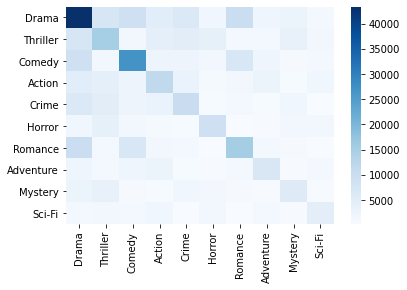

In [0]:
import seaborn as sns
sns.heatmap(output, cmap='Blues')

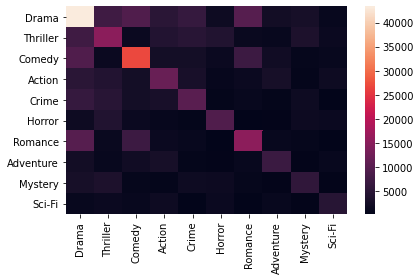

In [0]:
sns.heatmap(output)
plt.tight_layout()
plt.savefig("originalCoOccurrence.png",dpi=300)

In [0]:
# Options for cmap
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
# 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
# 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 
# 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 
# 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
# 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 
# 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 
# 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 
# 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
# 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 
# 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy...